In [2]:
import os

import numpy as np
import random
import pickle

from sklearn.preprocessing import LabelEncoder,OneHotEncoder

import keras
from keras.preprocessing import image,image_dataset_from_directory
import matplotlib.pyplot as plt
%matplotlib inline  

## Transfer learning

https://machinelearningmastery.com/transfer-learning-for-deep-learning/

Convolutional layers closer to the input layer of the model learn low-level features such as lines, that layers in the middle of the layer learn complex abstract features that combine the lower level features extracted from the input, and layers closer to the output interpret the extracted features in the context of a classification task.

A level of detail for feature extraction from an existing pre-trained model can be chosen. For example, if a new task is quite different from classifying objects in photographs (e.g. different to ImageNet), then perhaps the output of the pre-trained model after the few layers would be appropriate. If a new task is quite similar to the task of classifying objects in photographs, then perhaps the output from layers much deeper in the model can be used, or even the output of the fully connected layer prior to the output layer can be used.

1. used as a seperate feature extraction program -- output as input
2. integrated into a new NN model -- wieghts frozen
3. integrated into a new NN model -- initialized wieghts

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Conv2D, MaxPool2D, UpSampling2D
from keras.optimizers import SGD,Adagrad,RMSprop

In [4]:
from keras.applications import vgg16,resnet50,inception_v3
from keras.models import Model

In [4]:
class ResNet50_transf:
    model = None
    history = None
    
    def __init__(self,width,height,depth,num_classes,new=False):
        self.model = self.build(width,height,depth,num_classes,new)
    
    def build(self,width,height,depth,num_classes,new,kernel_initializer='RandomNormal'):
        input_shape = (width,height,depth)
        # load VGG16
        model = resnet50.ResNet50(include_top=False,input_shape=input_shape) # input_shape=input_shape
        for layer in model.layers:
            layer.trainable = False
        
        if new:
            # new classifier layers
            flat1 = Flatten()(model.layers[-1].output)
            class1 = Dense(1024,activation='relu')(flat1)
            output = Dense(num_classes,activation='softmax')(class1)

            # define new model
            model = Model(inputs=model.inputs,outputs=output)
        
        return model
    
    def train(self,data,labels,model_path,train_prop=0.3,batch_size=256,epochs=200,rs=0,shuffle_needed=0):
        if shuffle_needed==1:
            # shuffle data
            print('[INFO] shuffling data...')
            random.seed(rs)
            random.shuffle(data)
            random.seed(rs)
            random.shuffle(labels)
        
        # initialize model
        print('[INFO] compiling model...')
        self.model.compile(loss='sparse_categorical_crossentropy', # sparse_categorical_crossentropy 数字编码；categorical_crossentropy one-hot编码；binary_crossentropy 二分类
              optimizer=RMSprop(),
              metrics=['accuracy'])
        
        # train model
        self.history = self.model.fit(resnet50.preprocess_input(data),labels,validation_split=train_prop,
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=1)
        
        # save model
        self.model.save(model_path)
        
        # plot training loss and accuracy
        plt.style.use('ggplot')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(np.arange(0,epochs),self.history.history['loss'],label='train_loss')
        ax.plot(np.arange(0,epochs),self.history.history['val_loss'],label='val_loss')
        ax2 = ax.twinx()
        ax2.plot(np.arange(0,epochs),self.history.history['accuracy'],label='train_acc')
        ax2.plot(np.arange(0,epochs),self.history.history['val_accuracy'],label='val_acc')
        ax.set_title('Training Loss and Accuracy')
        ax.set_xlabel('Epoch #')
        ax.set_ylabel('Loss')
        ax2.set_ylabel('Accuracy')
        fig.legend(loc='lower left')
        plt.show()
        

In [5]:
def load_data(path,datasize_perlable=None,islabeled=0):
    print('[INFO] loading images...')
    data = []
    labels = []
    
    root, dirs, files = list(os.walk(path))[0]
    
    if islabeled==1:
        files_ = []
        for d in dirs:
            for f in os.listdir(path+'/'+d)[:datasize_perlable]:
                img = image.load_img(path+'/'+d+'/'+f,target_size=(224,224),) # interpolation='lanczos' -- better quality but worse performance(speed)
                img = image.img_to_array(img)
                data.append(img)
                
                labels.append(d)
                files_.append(path+'/'+d+'/'+f)
    else:
        files_ = []
        for f in files[:datasize_perlable]:
            img = image.load_img(path=path+'/'+f,target_size=(224,224),)
            img = image.img_to_array(img)
            data.append(img)
            
            files_.append(path+'/'+f)
    
    return data,labels,files_
    

In [24]:
%%time
data,labels,files_ = load_data('indoors/indoors/',islabeled=0)

[INFO] loading images...
Wall time: 8.69 s


In [28]:
# img = image.load_img('indoors/indoors/wework_99_8.jpg',target_size=(224,224))
# img = image.img_to_array(img)
# img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
imgs_ = resnet50.preprocess_input(np.array(data))
model = resnet50.ResNet50()
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)
pred = model.predict(imgs_)
# ResNet_classifier.model.predict(images)

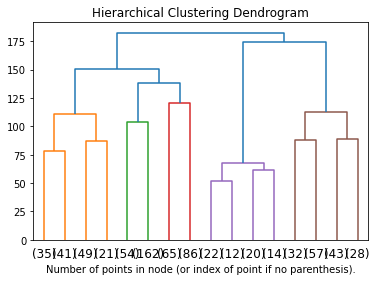

In [32]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pred)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Autoencoder

https://blog.keras.io/building-autoencoders-in-keras.html

Today two interesting practical applications of autoencoders are data denoising (which we feature later in this post), and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

Autoencoders are not a true unsupervised learning technique, but a self-supervised technique where the targets are generated from the input data. It have long been thought to be potential avenue for solving the problem of unsupervised learning. 

### simplest possible autoencoder 
#### -- a single fully-connected neural layer as encoder and as decoder

In [6]:
%%time
data,labels,files_ = load_data('indoors/indoors/',datasize_perlable=500,islabeled=0)

[INFO] loading images...
Wall time: 6.36 s


In [32]:
encoding_dim = 256

input_img = keras.Input(shape=(224*224*3,))
encoded = Dense(encoding_dim,activation='relu')(input_img)
encoded = Dense(1024,activation='relu')(encoded)
encoded = Dense(256,activation='relu')(encoded)
encoded = Dense(128,activation='relu')(encoded)
encoded = Dense(256,activation='relu')(encoded)
encoded = Dense(128,activation='relu')(encoded)
decoded = Dense(224*224*3,activation='sigmoid')(encoded)

autoencoder = Model(input_img,decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # per-pixel binary crossentropy loss


In [33]:
model = autoencoder.fit(np.array(data).reshape(len(data),224*224*3),np.array(data).reshape(len(data),224*224*3),epochs=10,batch_size=128,shuffle=True,validation_split=0.3,verbose=1)

Epoch 1/10
3/3 [==============================] - 3s 1s/step - loss: -139106.3594 - val_loss: -1563441.0000
Epoch 2/10
3/3 [==============================] - 2s 514ms/step - loss: -4549480.0000 - val_loss: -20640156.0000
Epoch 3/10
3/3 [==============================] - 1s 493ms/step - loss: -40218400.0000 - val_loss: -130798336.0000
Epoch 4/10
3/3 [==============================] - 2s 524ms/step - loss: -217873328.0000 - val_loss: -593768640.0000
Epoch 5/10
3/3 [==============================] - 2s 520ms/step - loss: -904977280.0000 - val_loss: -2194214656.0000
Epoch 6/10
3/3 [==============================] - 2s 535ms/step - loss: -3149926144.0000 - val_loss: -7042224640.0000
Epoch 7/10
3/3 [==============================] - 2s 531ms/step - loss: -9721486336.0000 - val_loss: -20281896960.0000
Epoch 8/10
3/3 [==============================] - 2s 522ms/step - loss: -27053629440.0000 - val_loss: -53628055552.0000
Epoch 9/10
3/3 [==============================] - 2s 503ms/step - loss: -6

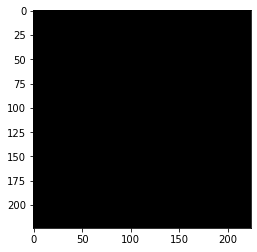

In [34]:
decoded_imgs = autoencoder.predict(np.array(data).reshape(len(data),224*224*3)[:1])
plt.imshow(image.array_to_img(decoded_imgs.reshape(224,224,3)))

In [7]:
kernel_initializer='RandomNormal'

input_img = keras.Input(shape=(224,224,3))
encoded = Conv2D(filters=6,kernel_size=(5,5),padding='same', # 'valid'=without padding
                         activation='relu',kernel_initializer=kernel_initializer)(input_img)
encoded = MaxPool2D(pool_size=(2,2))(encoded)
encoded = Conv2D(filters=16,kernel_size=(5,5),padding='same',
                         activation='relu',kernel_initializer=kernel_initializer)(encoded)
encoded = MaxPool2D(pool_size=(2,2))(encoded)
encoded = Conv2D(filters=16,kernel_size=(5,5),padding='same',
                         activation='relu',kernel_initializer=kernel_initializer)(encoded)
encoded = MaxPool2D(pool_size=(2,2))(encoded)

decoded = Conv2D(filters=16,kernel_size=(5,5),padding='same',
                         activation='relu',kernel_initializer=kernel_initializer)(encoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(filters=16,kernel_size=(5,5),padding='same',
                         activation='relu',kernel_initializer=kernel_initializer)(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(filters=16,kernel_size=(5,5),padding='same',
                         activation='relu',kernel_initializer=kernel_initializer)(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(filters=1,kernel_size=(5,5),padding='same',
                         activation='relu',kernel_initializer=kernel_initializer)(decoded)

autoencoder = Model(input_img,decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # per-pixel binary crossentropy loss


In [8]:
model = autoencoder.fit(np.array(data),np.array(data),epochs=10,batch_size=128,shuffle=True,validation_split=0.3,verbose=1)

Epoch 1/10
3/3 [==============================] - 16s 5s/step - loss: -2257.4106 - val_loss: -2400.3425
Epoch 2/10
3/3 [==============================] - 16s 5s/step - loss: -2346.0117 - val_loss: -2400.6670
Epoch 3/10
3/3 [==============================] - 16s 5s/step - loss: -2346.1450 - val_loss: -2400.6670
Epoch 4/10
3/3 [==============================] - 17s 6s/step - loss: -2346.1450 - val_loss: -2400.6670
Epoch 5/10
3/3 [==============================] - 16s 5s/step - loss: -2346.1445 - val_loss: -2400.6670
Epoch 6/10
3/3 [==============================] - 16s 5s/step - loss: -2346.1450 - val_loss: -2400.6670
Epoch 7/10
3/3 [==============================] - 16s 5s/step - loss: -2346.1450 - val_loss: -2400.6670
Epoch 8/10
3/3 [==============================] - 16s 5s/step - loss: -2346.1453 - val_loss: -2400.6670
Epoch 9/10
3/3 [==============================] - 16s 5s/step - loss: -2346.1448 - val_loss: -2400.6670
Epoch 10/10
3/3 [==============================] - 16s 5s/step -

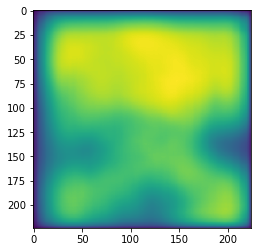

In [12]:
decoded_imgs = autoencoder.predict(np.array(data)[:1])
plt.imshow(image.array_to_img(decoded_imgs[0]))

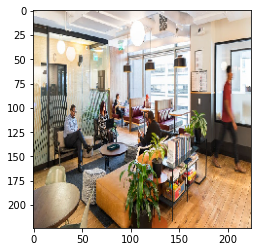

In [13]:
plt.imshow(image.array_to_img(np.array(data)[0]))